In [9]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import rasterio
import joblib
import pickle

from tqdm import tqdm
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.segmentation import felzenszwalb, quickshift, slic, watershed
from skimage import filters
from skimage.morphology import disk
from scipy import ndimage as nd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import confusion_matrix

In [10]:
def image_to_df(snow_path, mask_path, print_gabor=False, labeled=True):
    #load in images
    img = cv2.imread(snow_path)
    if labeled:
        mask = rasterio.open(mask_path)
    
    #generate grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #flatten image
    img2 = img.reshape((-1,3))

    #create dataframe
    df = pd.DataFrame(img2, columns=['Blue', 'Green', 'Red'])
    df['Gray'] = gray.reshape(-1)

    #gabor filter
    num = 1
    gabors = [5, 11, 23, 8, 6, 4]
    kernels = []
    for theta in range(2):
        theta = theta / 4. * np.pi
        for sigma in (1,3):
            for lamda in np.arange(0, np.pi, np.pi/4):
                for gamma in (.05, .5):
                    if num in gabors:
                        gabor_label = 'Gabor' + str(num)
                        ksize = 9
                        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
                        kernels.append(kernel)

                        fimg = cv2.filter2D(gray, cv2.CV_8UC3, kernel)
                        filtered_img = fimg.reshape(-1)
                        df[gabor_label] = filtered_img
                        if print_gabor:
                            print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                    num += 1

    #Roberts Edge
    roberts_edge = roberts(gray).reshape(-1)
    df['Roberts'] = roberts_edge

    #Sobel Edge
    sobel_edge = sobel(gray).reshape(-1)
    df['Sobel'] = sobel_edge

    #Scharr Edge
    scharr_edge = scharr(gray).reshape(-1)
    df['Scharr'] = scharr_edge

    #Prewitt Edge
    prewitt_edge = prewitt(gray).reshape(-1)
    df['Prewitt'] = prewitt_edge

    gaussian_img = nd.gaussian_filter(gray, sigma=3).reshape(-1)
    df['Gaussian s3'] = gaussian_img

    gaussian_img2 = nd.gaussian_filter(gray, sigma=7).reshape(-1)
    df['Gaussian s7'] = gaussian_img2

    median_img =  nd.median_filter(gray, size=3).reshape(-1)
    df['Median s3'] = median_img

    #segmentation
    #felzenszwalb
    segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
    df['Felzenszwalb'] = segments_fz.reshape(-1)

    #quickshift
    segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
    df['Quickshift'] = segments_quick.reshape(-1)

    #slic
    segments_slic = slic(img, n_segments=250, compactness=10, sigma=1)
    df['SLIC'] = segments_slic.reshape(-1)

    #watershed
    gradient = filters.rank.gradient(gray, disk(2))
    segments_ws = watershed(gradient, markers=250, compactness=0.001)
    df['Watershed'] = segments_ws.reshape(-1)

    #labels
    if labeled:
        df['labels'] = mask.read(1).reshape(-1)

    return df

In [11]:
def visualize(img, mask, pred_image, accuracy = None, confusion_matrix = None, location=None, date=None):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Display original image
    axs[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title('Original Image')

    # Display mask
    axs[0, 1].imshow(mask.read(1), cmap='gray')
    axs[0, 1].set_title('Mask')

    # Display predicted image
    axs[1, 0].imshow(pred_image, cmap='jet')
    axs[1, 0].set_title('Predicted Image')

    # Display confusion matrix as table (if provided)
    if confusion_matrix is not None:
        axs[1, 1].axis('tight')
        axs[1, 1].axis('off')

        #change everything to percents
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

        #multiply by 100 and round to 4 decimal places, then convert to strings and add % sign
        confusion_matrix = np.round(confusion_matrix * 100, 3).astype(str)
        confusion_matrix = np.char.add(confusion_matrix, '%')
        
        # Create the table
        table_data = [[''] + [f'Pred {i}' for i in range(confusion_matrix.shape[1])]]  # Header row
        for i in range(confusion_matrix.shape[0]):
            row = [f'True {i}'] + list(confusion_matrix[i])
            table_data.append(row)
        
        # Add the table to the subplot
        table = axs[1, 1].table(cellText=table_data, loc='center', cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 1.2)
        table.auto_set_column_width([0,1])
        axs[1, 1].set_title('Confusion Matrix')
        
        # Add accuracy text near the confusion matrix
        if accuracy is not None:
            axs[1, 1].text(0.5, -0.1, f'Accuracy: {accuracy}', horizontalalignment='center', verticalalignment='center', fontsize=12, transform=axs[1, 1].transAxes)
    elif accuracy is not None:
        # Display accuracy text in place of confusion matrix
        axs[1, 1].text(0.5, 0.5, f'Accuracy: {accuracy}', horizontalalignment='center', verticalalignment='center', fontsize=12)
        axs[1, 1].axis('off')
    else:
        axs[1, 1].text(0.5, 0.5, 'No Confusion Matrix or Accuracy Provided', horizontalalignment='center', verticalalignment='center', fontsize=12)
        axs[1, 1].axis('off')

    if location is not None and date is not None:
        plt.suptitle(f'Location: {location}, Date: {date}')
    elif location is not None:
        plt.suptitle(f'Location: {location}')
    elif date is not None:
        plt.suptitle(f'Date: {date}')

    plt.tight_layout()
    plt.show()

Data prep

In [12]:
#read in the data
csv_df = pd.read_csv('data/640/640.csv')

images_df = image_to_df(csv_df['snow_path'][0], csv_df['snowbinary_path'][0], print_gabor=True)

for i in tqdm(range(1, len(csv_df)), unit='image'):
    images_df = pd.concat([images_df, image_to_df(csv_df['snow_path'][i], csv_df['snowbinary_path'][i])])
images_df.shape

Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor23 : theta= 0.7853981633974483 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05


100%|██████████| 130/130 [21:18<00:00,  9.83s/image]


(52970240, 22)

In [15]:
#remove all black pixels
trimmed_df = images_df[(images_df[['Blue', 'Green', 'Red']] != 0).all(axis=1)]
trimmed_df.shape

(24723829, 22)

In [17]:
#black pixels made up this mount of the data
1- 24723829/52970240

0.533250576172583

In [18]:
X = trimmed_df.drop(columns=['labels'], axis=1)
y = trimmed_df['labels'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model Training

In [19]:
#define the model
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=8, verbose=1)

In [20]:
rf.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 18.6min
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed: 26.0min finished


RandomForestClassifier(n_estimators=50, n_jobs=8, random_state=42, verbose=1)

In [21]:
joblib.dump(rf, '640_no_black.joblib')

['640_no_black.joblib']

Model Analysis

In [22]:
feature_list = list(X.columns)
feature_imp = pd.Series(rf.feature_importances_, index=feature_list).sort_values(ascending=False)
feature_imp

Blue            0.314153
Median s3       0.132996
Roberts         0.063000
Gray            0.058700
Gaussian s7     0.056868
Gaussian s3     0.055570
Green           0.051444
Sobel           0.043532
Scharr          0.042785
Red             0.037572
Prewitt         0.035650
Felzenszwalb    0.028298
Quickshift      0.017876
Watershed       0.013711
Gabor6          0.011817
SLIC            0.010855
Gabor5          0.006958
Gabor8          0.006565
Gabor23         0.005095
Gabor4          0.004940
Gabor11         0.001615
dtype: float64

In [23]:
#test model
y_pred = rf.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:   16.0s finished


Accuracy: 0.9829995999810709


C:\Users\apfox\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:   15.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   11.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:   15.1s finished


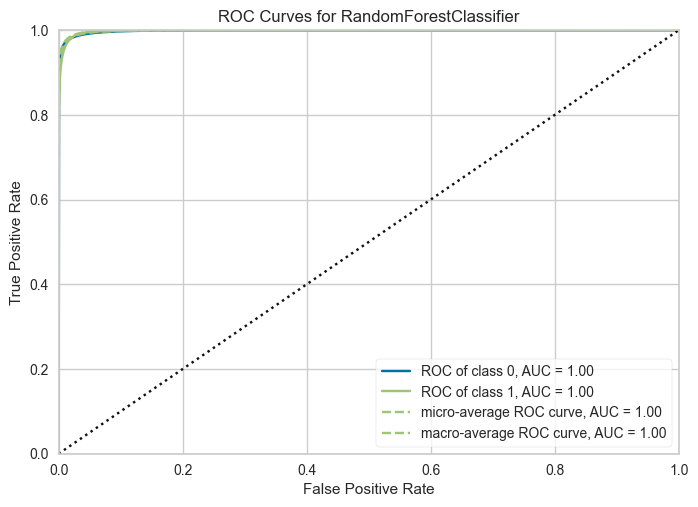

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [24]:
#ROC curve
visualizer = ROCAUC(rf, classes=[0, 1])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

Visualization

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


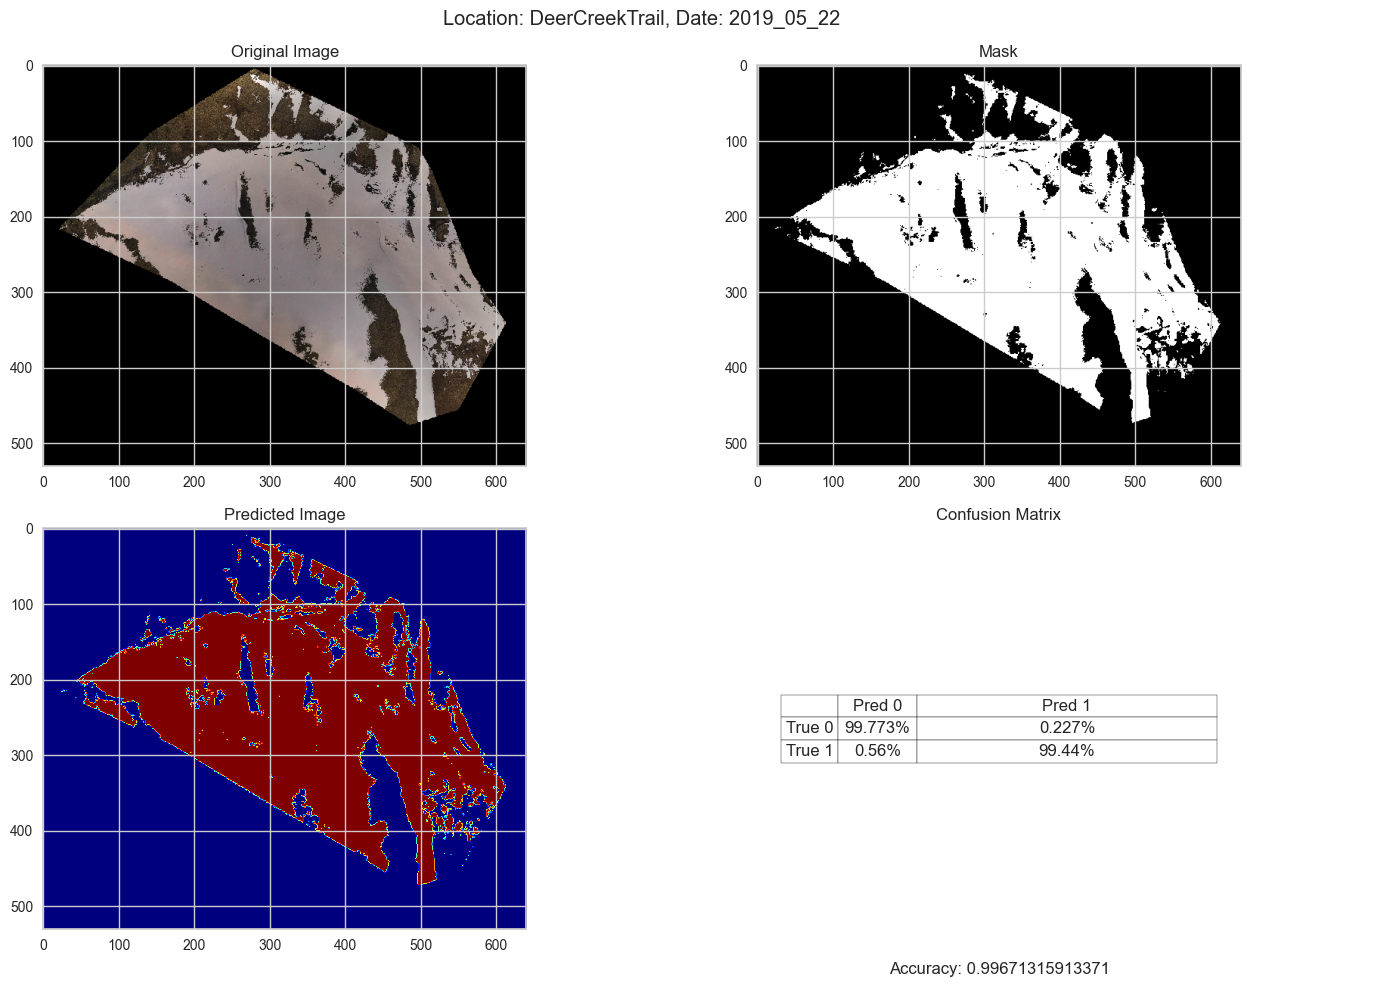

In [25]:
img = cv2.imread(csv_df['snow_path'][0])
mask = rasterio.open(csv_df['snowbinary_path'][0])

img_df_labeled = image_to_df(csv_df['snow_path'][0], csv_df['snowbinary_path'][0])
img_df = img_df_labeled.drop(columns=['labels'], axis=1)

#get predicition
pred_img = rf.predict(img_df)
pred_img_reshaped = pred_img.reshape(img.shape[0], img.shape[1])

#check accuracy
accuracy = metrics.accuracy_score(img_df_labeled['labels'].values, pred_img)

#confusion matrix
conf_matrix = confusion_matrix(img_df_labeled['labels'].values, pred_img)

visualize(img, mask, pred_img_reshaped, accuracy, conf_matrix, location=csv_df['location'][0], date=csv_df['date'][0])

Assess accuracy on all images

In [26]:
#separate images_df into x and y
X = images_df.drop(columns=['labels'], axis=1)
y = images_df['labels'].values

#get predictions for all pixels
predictions = rf.predict(X)

#check accuracy
accuracy = metrics.accuracy_score(y, predictions)

#confusion matrix
conf_matrix = confusion_matrix(y, predictions)

#display results
print('Accuracy:', accuracy)
print('Confusion Matrix:', conf_matrix)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   46.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:  1.1min finished


Accuracy: 0.998063214363386
Confusion Matrix: [[47357170    42196]
 [   60396  5510478]]


In [27]:
#display conf matrix as percent
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = np.round(conf_matrix * 100, 3).astype(str)
conf_matrix = np.char.add(conf_matrix, '%')
conf_matrix

array([['99.911%', '0.089%'],
       ['1.084%', '98.916%']], dtype='<U33')